In [20]:
import os
import getpass
USERNAME = getpass.getuser()
os.environ['HF_HOME'] = f'/home/sharifm/teaching/tml-0368-4075/2024-spring/students/{USERNAME}/.cache/hugging_face'

In [21]:
import torch

# Huggingface ASR dataset to be tested
DATASET = 'google/fleurs'
LANGUAGE = 'en_us'
SPLIT = 'test'

# Whisper model name, can be one of the following: tiny/tiny.en/base/base.en/small/small.en/medium/medium.en
WHISPER_MODEL = 'tiny'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
# Load the pre-trained OpenAI Whisper model
import whisper

model = whisper.load_model(WHISPER_MODEL).to(DEVICE)

/home/sharifm/teaching/tml-0368-4075/2024-spring/students/shmulikcohen/anaconda3/envs/shmulc_env/lib/python3.9/site-packages/whisper/__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

In [23]:
# Automatically download and load Huggingface dataset
from datasets import load_dataset

dataset = load_dataset(DATASET, LANGUAGE, split=SPLIT, trust_remote_code=True)

In [24]:
# Load the relevant universal acoustic adversarial attack segment (0.64 seconds in length)
import numpy as np

# Could be any of ["fr", "ru", "slm", "a"]
TOKEN = "a"

loaded_array = np.load(f"audio_attack_segments/arbitrary_tokens/attack_segment_{TOKEN}.np.npy")
audio_attack_segment = torch.from_numpy(loaded_array).to(DEVICE)

In [25]:
token_distribution = []

# Hook to extract final logits (token distribution)
def hook_fn(module, input, output):
    # Output contains the final token distribution
    global token_distribution
    global index
    token_distribution.append(output[0][0])
    

# Register hook to the final layer of the model
hook_handle = model.decoder.register_forward_hook(hook_fn)

# Remove hook after extraction
hook_handle.remove()

# Get the logits saved by the hook
logits = token_distribution

# Print the final token distribution (logits)
if logits is not None:
    #print("Final token distribution (logits):", logits)
    pass
else:
    print("No token distribution captured.")

In [26]:

import random
import nltk
from whisper.audio import load_audio
from sentence_transformers import SentenceTransformer, util

random.seed(10)

TOKENIZERS_PARALLELISM = False
reg_len_sum = 0
reg_len_list = []
attk_len_sum = 0
attk_len_list = []
edit_dist_sum = 0
edit_dist_list = []
cosin_sum = 0
cosin_list = []
NUM_SAMPLE = 100
model_sim = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
for iter in range(NUM_SAMPLE):
    
    idx = random.randint(0, len(dataset)-1)

    # Prepare the path of the selected utterance
    audio_path = os.path.join(os.path.dirname(dataset[idx]['path']), dataset[idx]['audio']['path'])
    audio = load_audio(audio_path)
    audio = torch.from_numpy(audio).to(DEVICE)
    reg_transc = model.transcribe(audio)["text"]
    reg_len_sum += len(reg_transc)
    reg_len_list.append(len(reg_transc))
    
    
    audio_with_prompts = torch.cat((audio_attack_segment, audio), dim=0)


    token_distribution = []
    
    hook_handle = model.decoder.register_forward_hook(hook_fn)
    
    attk_transc = model.transcribe(audio_with_prompts)["text"]

    # Remove hook after extraction
    hook_handle.remove()

    # Get the logits saved by the hook
    logits = token_distribution

    # Print the final token distribution (logits)
    if logits is not None:
        #print("Final token distribution (logits):", logits)
        pass
    else:
        print("No token distribution captured.")

    # Optionally, you can process logits to get the token predictions (e.g., using softmax to get probabilities)
    probabilities = []
    for i in token_distribution:    
        probabilities.append(torch.softmax(i, dim=-1))  # Apply softmax to get probabilities
    top5 = []
    for i in token_distribution:    
        top5.append(i.argsort(dim=0, descending=True)[:1].item())
    attk_len_sum += len(top5)
    attk_len_list.append(len(top5))

    edit_d = nltk.edit_distance(reg_transc.split(), attk_transc.split())
    edit_dist_sum += edit_d
    edit_dist_list.append(edit_d)

    sentences = [reg_transc, attk_transc]

    #Compute embedding for both lists
    embedding_1= model_sim.encode(sentences[0], convert_to_tensor=True)
    embedding_2 = model_sim.encode(sentences[1], convert_to_tensor=True)

    cossim = util.pytorch_cos_sim(embedding_1, embedding_2)[0][0].item()
    cosin_sum += cossim
    cosin_list.append(cossim)

print("average output length without attack:")
print(reg_len_sum/NUM_SAMPLE)
print("average output length with attack:")
print(attk_len_sum/NUM_SAMPLE)
print("average edit dist:")
print(edit_dist_sum/NUM_SAMPLE)
print("average cosin sim:")
print(cosin_sum/NUM_SAMPLE)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

average output length without attack:
130.7
average output length with attack:
54.8
average edit dist:
19.05
average cosin sim:
0.2556374890822917


In [33]:
from sentence_transformers import SentenceTransformer, util
NUM_SAMPLE = 300
sum = 0
cosin_sum = 0
model_sim = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
for i in range(NUM_SAMPLE):
    idx1 = random.randint(0, len(dataset)-1)
    idx2 = random.randint(0, len(dataset)-1)


    sum += nltk.edit_distance(dataset[idx1]["transcription"].split(),dataset[idx2]["transcription"].split())

    sentences = [dataset[idx1]["transcription"], dataset[idx2]["transcription"]]

    #Compute embedding for both lists
    embedding_1= model_sim.encode(sentences[0], convert_to_tensor=True)
    embedding_2 = model_sim.encode(sentences[1], convert_to_tensor=True)

    cosin_sum += util.pytorch_cos_sim(embedding_1, embedding_2)[0][0].item()

print(sum/NUM_SAMPLE)
print(cosin_sum/NUM_SAMPLE)

25.046666666666667
0.03683517354540527


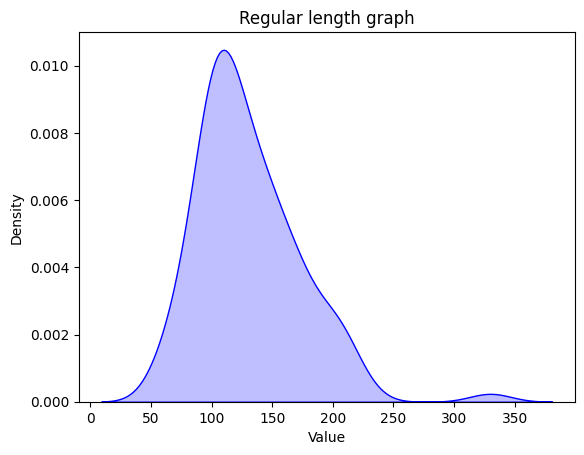

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting the KDE (continuous version of histogram)
sns.kdeplot(reg_len_list, color='blue', fill=True)  # fill=True adds shading under the curve
plt.title('Regular length graph')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

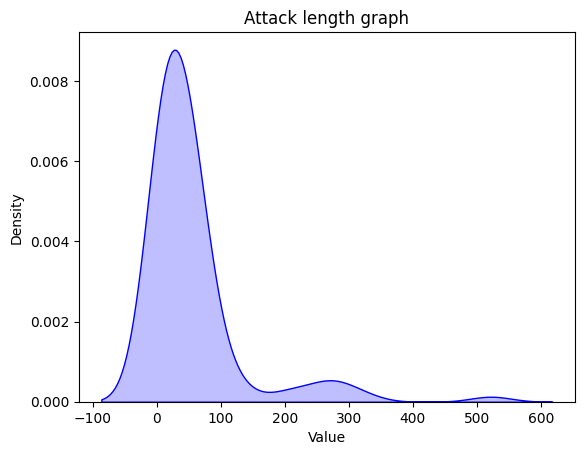

In [35]:
sns.kdeplot(attk_len_list, color='blue', fill=True)  # fill=True adds shading under the curve
plt.title('Attack length graph')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

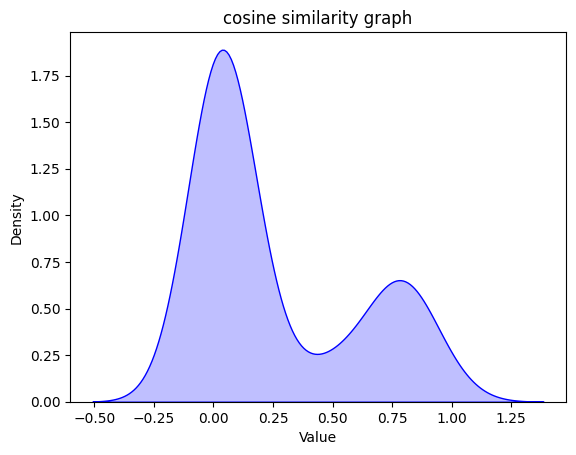

In [36]:
sns.kdeplot(cosin_list, color='blue', fill=True)  # fill=True adds shading under the curve
plt.title('cosine similarity graph')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

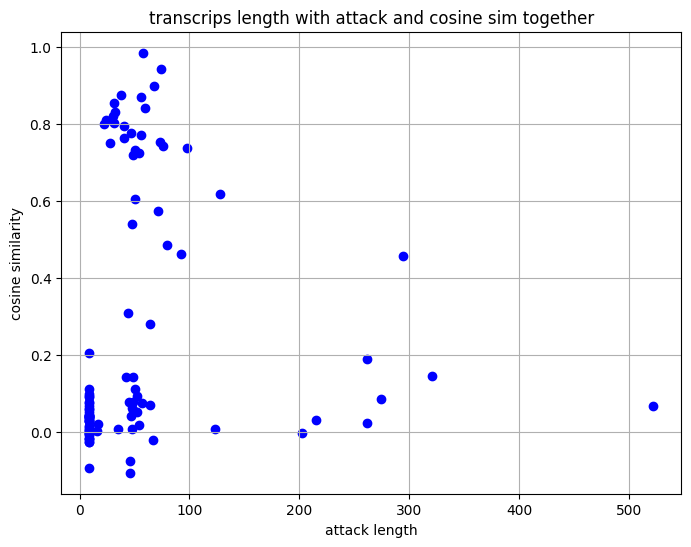

In [37]:
plt.figure(figsize=(8, 6))  # Set figure size
plt.scatter(attk_len_list, cosin_list, color='blue', marker='o')  # Plot points

# Labeling the plot
plt.title("transcrips length with attack and cosine sim together")
plt.xlabel("attack length")
plt.ylabel("cosine similarity")

# Showing grid and plot
plt.grid(True)
plt.show()

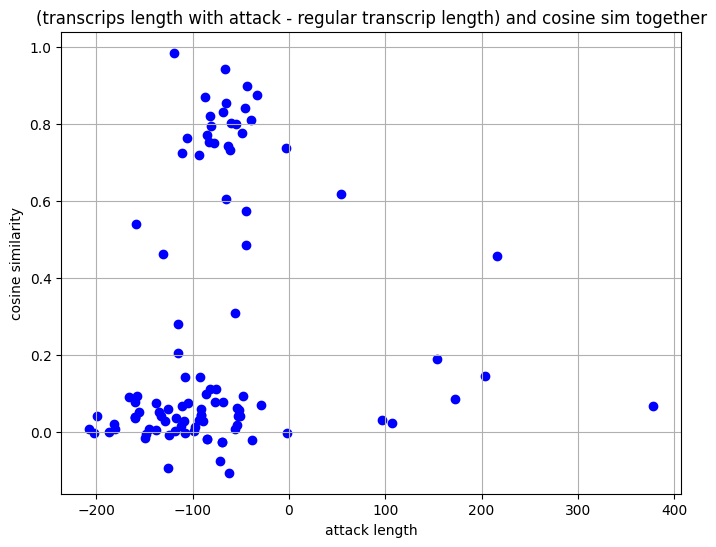

In [38]:
plt.figure(figsize=(8, 6))  # Set figure size
new_list = []
for (i,j) in zip(reg_len_list,attk_len_list):
    new_list.append(j-i)
plt.scatter(new_list, cosin_list, color='blue', marker='o')  # Plot points

# Labeling the plot
plt.title("(transcrips length with attack - regular transcrip length) and cosine sim together")
plt.xlabel("attack length")
plt.ylabel("cosine similarity")

# Showing grid and plot
plt.grid(True)
plt.show()